In [1]:
import numpy as np
import numpy.matlib as mb
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import scipy as sp
from sklearn import preprocessing, linear_model

In [2]:
cam0_imgs = pd.read_csv('MH_01_easy/mav0/cam0/data.csv')
cam1_imgs = pd.read_csv('MH_01_easy/mav0/cam1/data.csv')
cam0_path = 'MH_01_easy/mav0/cam0/data/'
cam1_path = 'MH_01_easy/mav0/cam1/data/'
pose_it = 0
end = len(cam0_imgs)-1
Rotacao = []
translacao = []
initial_position = np.array([0, 0, 0], ndmin = 2)
position = []
position.append(initial_position)

#cam0

cam0_K = np.matrix([[458.654, 0, 367.215],
                   [0, 457.296, 248.375],
                   [0, 0, 1]])

cam0_T_BS = np.matrix([[0.0148655429818, -0.999880929698, 0.00414029679422, -0.0216401454975],
                     [0.999557249008, 0.0149672133247, 0.025715529948, -0.064676986768],
                     [-0.0257744366974, 0.00375618835797, 0.999660727178, 0.00981073058949],
                     [0.0, 0.0, 0.0, 1.0]])

cam0_Dist = np.matrix([-0.28340811, 0.07395907, 0.00019359, 1.76187114e-05])

cam0_P = np.matrix([[435.2046959714599, 0, 367.4517211914062, 0], 
                    [0, 435.2046959714599, 252.2008514404297, 0], 
                    [0, 0, 1, 0]
])

#cam1

cam1_K = np.matrix([[457.587, 0, 379.999],
                   [0, 456.134, 255.238],
                   [0, 0, 1]])

cam1_T_BS = np.matrix([[0.0125552670891, -0.999755099723, 0.0182237714554, -0.0198435579556],
                     [0.999598781151, 0.0130119051815, 0.0251588363115, 0.0453689425024],
                     [-0.0253898008918, 0.0179005838253, 0.999517347078, 0.00786212447038],
                     [0.0, 0.0, 0.0, 1.0]])

cam1_Dist = np.matrix([-0.28368365,  0.07451284, -0.00010473, -3.55590700e-05])

cam1_P = np.matrix([[435.2046959714599, 0, 367.4517211914062, -47.90639384423901], 
                    [0, 435.2046959714599, 252.2008514404297, 0], 
                    [0, 0, 1, 0]
])

fast = cv.FastFeatureDetector_create()
brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
bf2 = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=False)

In [3]:
def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        #print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

In [4]:
while pose_it < end:
    
    #Leitura das imagens da câmera da esquerda

    img00 = cv.imread(cam0_path + cam0_imgs.at[pose_it,'filename'])
    img01 = cv.imread(cam1_path + cam1_imgs.at[pose_it,'filename'])

    #Leitura das imagens da câmera da direita

    img10 = cv.imread(cam0_path + cam0_imgs.at[pose_it+1,'filename'])
    img11 = cv.imread(cam1_path + cam1_imgs.at[pose_it+1,'filename'])

    #Detecção de pontos (FAST)

    kp00 = fast.detect(img00,None)
    kp01 = fast.detect(img01,None)

    kp10 = fast.detect(img00,None)
    kp11 = fast.detect(img01,None)

    #Cálculo dos descritores (BRIEF)

    kp00, des00 = brief.compute(img00,kp00)
    kp01, des01 = brief.compute(img01,kp01)

    kp10, des10 = brief.compute(img10,kp10)
    kp11, des11 = brief.compute(img11,kp11)

    #matching das imagens da câmera da esquerda em t e t+1

    matches01 = bf.match(des00, des10)
    
    new_kp00 = []
    new_kp10 = []

    new_des00 = []
    new_des10 = []

    pts00 = []
    pts10 = []

    for match in matches01:
    
        img00_idx = match.queryIdx
        img10_idx = match.trainIdx
    
        new_kp00.append(kp00[img00_idx])
        new_kp10.append(kp10[img10_idx])
    
        new_des00.append(des00[img00_idx])
        new_des10.append(des10[img10_idx])
    
        pts00.append(kp00[img00_idx].pt)
        pts10.append(kp10[img10_idx].pt)

    new_des00 = np.array(new_des00)
    new_des10 = np.array(new_des10)

    new_kp00 = np.array(new_kp00)
    new_kp10 = np.array(new_kp10)

    pts00 = np.int32(pts00)
    pts10 = np.int32(pts10)

    F, inliers = cv.findFundamentalMat(pts00, pts10, cv.FM_RANSAC, 3.0, 0.99, 1000)

    for i in range(0,len(inliers)):
        if inliers[i] == 0:
            np.delete(pts00,i)
            np.delete(pts10,i)
        
            np.delete(new_kp00,i)
            np.delete(new_kp10,i)
        
            np.delete(new_des00,i)
            np.delete(new_des10,i)
    
    #Matching entre as câmeras da esquerda e da direita em t e t+1

    matches00 = bf2.match(new_des00, des01)
    matches11 = bf2.match(new_des10, des11)

    #extração das coordenadas dos keypoints

    pts00 = []
    pts01 = []

    pts10 = []
    pts11 = []

    for i in range(0,len(matches00)):
        if matches00[i].distance < 15 and matches11[i].distance < 15:
            pts00.append(new_kp00[matches00[i].queryIdx].pt)
            pts01.append(kp01[matches00[i].trainIdx].pt)
            pts10.append(new_kp10[matches11[i].queryIdx].pt)
            pts11.append(kp11[matches11[i].trainIdx].pt)
        
    pts00 = np.int32(pts00)
    pts01 = np.int32(pts01)
    pts10 = np.int32(pts10)
    pts11 = np.int32(pts11)
    
    #Triangulação em t

    pts00_3D = np.ones((3, pts00.shape[0]))
    pts01_3D = np.ones((3, pts01.shape[0]))

    pts00_3D[0], pts00_3D[1] = pts00[:, 0].copy(), pts00[:, 1].copy()
    pts01_3D[0], pts01_3D[1] = pts01[:, 0].copy(), pts01[:, 1].copy()

    X0 = cv.triangulatePoints(cam0_P, cam1_P, pts00_3D[:2], pts01_3D[:2])

    X0 = X0/X0[3]

    #Triangulação em t+1

    pts10_3D = np.ones((3, pts10.shape[0]))
    pts11_3D = np.ones((3, pts11.shape[0]))

    pts10_3D[0], pts10_3D[1] = pts10[:, 0].copy(), pts10[:, 1].copy()
    pts11_3D[0], pts11_3D[1] = pts11[:, 0].copy(), pts11[:, 1].copy()

    X1 = cv.triangulatePoints(cam0_P, cam1_P, pts10_3D[:2], pts11_3D[:2])

    X1 = X1/X1[3]
    
    R, t = rigid_transform_3D(X0[:3,:],X1[:3,:])

    Rotacao.append(R)
    translacao.append(t)
    
    pose_it += 1

In [5]:
Rotacao = np.array(Rotacao)
translacao = np.array(translacao)

In [6]:
position = []
position.append(initial_position)

for i in range(0, len(Rotacao)):
    
    new_position = Rotacao[i] @ np.array(position[i][0]) + translacao[i].T
    position.append(new_position)

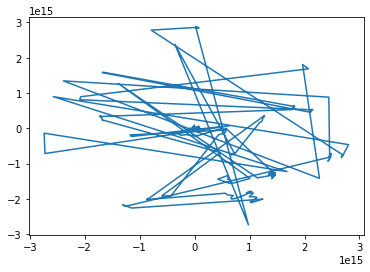

In [7]:
x = []
y = []
z = []

for p in position:
    x.append(p[0][0])
    y.append(p[0][1])
    z.append(p[0][2])
    
plt.plot(x[:], y[:], '-')
plt.show()

In [8]:
leica = pd.read_csv('MH_01_easy/mav0/leica0/data.csv')

leica.head()

,#timestamp [ns],p_RS_R_x [m],p_RS_R_y [m],p_RS_R_z [m]
0,1403636578922881280,4.782300,-1.815574,0.844627
1,1403636578968881408,4.782212,-1.814786,0.857671
2,1403636579022881280,4.780753,-1.813192,0.874624
3,1403636579068881152,4.779119,-1.812024,0.891923
4,1403636579118881280,4.778764,-1.811006,0.911809


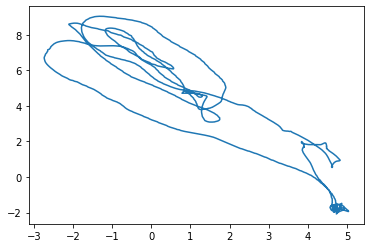

In [9]:
plt.plot(leica['p_RS_R_x [m]'], leica['p_RS_R_y [m]'], '-')
plt.show()

In [10]:
for p in position:
    print(p)

[[0 0 0]]
[[   0.20484928    5.5242406  -158.89088691]]
[[   9.58740158  -26.91570071 -151.23413192]]
[[  81.30480369   30.39876882 -119.0737676 ]]
[[  96.49470966  -16.81989783 -148.26089806]]
[[ 100.20791124  -14.94064108 -130.04423397]]
[[ 101.31070806   -9.65263486 -132.1913509 ]]
[[ -67.65772207   93.0892593  -191.37817755]]
[[ -66.87893883   88.24401395 -191.49815316]]
[[ -67.74625997   90.17989688 -190.43461787]]
[[ -70.78498768  108.7069045  -264.34776013]]
[[  40.36540902 -112.84066932  268.54914582]]
[[ 18.36745812 -82.93579268 324.62316221]]
[[  29.56553604 -124.86943487  429.37389323]]
[[  27.63761006 -122.82583097  408.14989624]]
[[-118.71518598  124.05847689 -389.57293875]]
[[-123.53740573  130.14566433 -385.21828247]]
[[-124.31200773  128.46167494 -380.29381599]]
[[-126.95733533  131.24105814 -393.91449016]]
[[-128.36050222  103.97495146 -367.17328011]]
[[-126.05675992   90.82570182 -347.87469938]]
[[   -3.78045272   338.74918699 -1607.47720828]]
[[  219.20332759   226.8

[[4.11621658e+12 1.36808097e+13 2.60839853e+12]]
[[-1.02198149e+13  1.01976315e+13  1.57328654e+12]]
[[-1.02462763e+13  1.01082001e+13  1.93640110e+12]]
[[2.02972579e+12 1.42818583e+13 1.67936691e+12]]
[[ 5.22524251e+12 -9.16908219e+11 -1.35191589e+13]]
[[ 6.18621797e+12 -6.16084773e+11 -1.31248879e+13]]
[[ 5.81340242e+12 -6.61017098e+11 -1.32920632e+13]]
[[ 6.18168594e+12 -6.15480187e+11 -1.31270514e+13]]
[[ 5.18937595e+12 -1.00978820e+12 -1.35263536e+13]]
[[ 5.27188772e+12 -1.07402208e+12 -1.34894482e+13]]
[[ 4.85802816e+12 -2.37555108e+12 -1.34784219e+13]]
[[-1.08555331e+13 -8.56425411e+12  4.44100103e+12]]
[[-1.01113213e+13 -8.39835991e+12  6.17578083e+12]]
[[-9.97854025e+12 -8.50744396e+12  6.24208845e+12]]
[[-9.75520952e+12 -8.86462566e+12  6.09637891e+12]]
[[-7.55854113e+12 -1.01944276e+13  7.06071083e+12]]
[[-7.52834633e+12 -1.01042885e+13  7.22072653e+12]]
[[-7.03844696e+12 -1.05406646e+13  7.08986536e+12]]
[[-8.24754403e+12 -9.42412551e+12  7.35359859e+12]]
[[-8.62738601e+12 

[[ 5.78157768e+11 -3.07706445e+12 -1.06675387e+13]]
[[ 5.74466652e+11 -3.08057865e+12 -1.06667238e+13]]
[[ 6.67895832e+11 -3.00803071e+12 -1.06819773e+13]]
[[ 4.06269831e+11 -3.19960299e+12 -1.06393824e+13]]
[[ 4.13250905e+11 -3.19331929e+12 -1.06410013e+13]]
[[ 4.17074046e+11 -3.19194733e+12 -1.06412638e+13]]
[[-8.99995525e+12  5.78535324e+12 -3.02150069e+12]]
[[-8.87545049e+12  5.96523164e+12 -3.03996103e+12]]
[[-7.79143394e+12  7.31254749e+12 -3.06906817e+12]]
[[-7.58472640e+12  7.51111344e+12 -3.10710047e+12]]
[[-7.71363731e+12  7.37213835e+12 -3.12255483e+12]]
[[-7.72359393e+12  7.33955070e+12 -3.17428186e+12]]
[[ 1.85301791e+11 -2.62908524e+12 -1.08005809e+13]]
[[-1.92732019e+11 -2.88378028e+12 -1.07352522e+13]]
[[ 1.48141515e+11 -2.62043198e+12 -1.08032571e+13]]
[[ 2.60285790e+11 -2.50322870e+12 -1.08288998e+13]]
[[ 2.89481657e+11 -2.53964753e+12 -1.08196749e+13]]
[[ 3.15362081e+11 -2.55925306e+12 -1.08143305e+13]]
[[ 3.16588223e+11 -2.57113803e+12 -1.08114751e+13]]
[[ 3.1359111

In [11]:
T = []

for i in range(0, len(Rotacao)):
    
    T.append(np.array([[Rotacao[i][0][0], Rotacao[i][0][1], Rotacao[i][0][2], translacao[i][0][0]], 
                       [Rotacao[i][1][0], Rotacao[i][1][1], Rotacao[i][1][2], translacao[i][1][0]],
                       [Rotacao[i][2][0], Rotacao[i][2][1], Rotacao[i][2][2], translacao[i][2][0]],
                       [0, 0, 0, 1]]))
    print(T[i])

[[ 9.95204956e-01  9.77960773e-02 -1.73882274e-03  2.04849282e-01]
 [ 9.77989185e-02 -9.95204858e-01  1.63166370e-03  5.52424060e+00]
 [-1.57091453e-03 -1.79389478e-03 -9.99997157e-01 -1.58890887e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ -0.94900829  -0.31434065  -0.02394219   7.7141034 ]
 [  0.31367071  -0.94911875   0.02800512 -17.28703795]
 [ -0.03152712   0.01906712   0.99932101   7.44999692]
 [  0.           0.           0.           1.        ]]
[[-7.87983229e-01 -1.02039876e-02 -6.15612142e-01 -4.51669996e+00]
 [ 1.30653257e-02 -9.99914634e-01 -1.49673872e-04  3.33746748e+00]
 [-6.15558062e-01 -8.16111366e-03  7.88049281e-01  5.78812151e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-6.05568228e-01  9.80374055e-02 -7.89731466e-01  4.87137981e+01]
 [-1.69337944e-02 -9.93745318e-01 -1.10378842e-01  1.62231061e+00]
 [-7.95613202e-01 -5.34687696e-02  6.03440737e-01 -1.00943760e+01]
 [ 0.00000000e+00  0.00000000e+00  0.000

[[ 0.9999319  -0.01085393 -0.00428732 -0.03338416]
 [ 0.01081719  0.99990534 -0.0085032   0.05405365]
 [ 0.0043792   0.00845624  0.99995466 -0.21801996]
 [ 0.          0.          0.          1.        ]]
[[ 0.7819011   0.33811455 -0.52374538 -3.52543673]
 [ 0.34728422 -0.93394802 -0.08446757  3.39302273]
 [-0.51771067 -0.11584322 -0.84767683 -7.81334949]
 [ 0.          0.          0.          1.        ]]
[[  0.06539094   0.04410921  -0.99688435  -1.95271616]
 [  0.02751612  -0.99872235  -0.04238561   6.21950255]
 [ -0.99748027  -0.02465876  -0.06652111 -16.5944137 ]
 [  0.           0.           0.           1.        ]]
[[-0.55180602  0.12772308 -0.82413405 -4.58594327]
 [ 0.15682057 -0.95468349 -0.252956    4.56046702]
 [-0.81909549 -0.26882382  0.50677049 -7.33701445]
 [ 0.          0.          0.          1.        ]]
[[ 9.99994673e-01  3.00617276e-03 -1.27171126e-03  5.24739033e-01]
 [-3.01520495e-03  9.99969813e-01 -7.16112290e-03 -1.05394191e+00]
 [ 1.25014530e-03  7.16491922e

[[ 9.99958928e-01  8.27523745e-04  9.02534134e-03  1.27683366e+00]
 [-8.06685086e-04  9.99997001e-01 -2.31230129e-03 -6.35677851e+01]
 [-9.02722776e-03  2.30492572e-03  9.99956597e-01  1.74387074e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99987866e-01 -4.28172702e-03  2.43604266e-03  3.17444757e-01]
 [ 4.28627486e-03  9.99989075e-01 -1.86474930e-03 -1.27775973e+01]
 [-2.42803170e-03  1.87516822e-03  9.99995294e-01  3.31499832e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99802516e-01 -1.95688956e-02  3.46225125e-03  3.63571522e+00]
 [ 1.95825129e-02  9.99800466e-01 -3.94388290e-03 -7.76552717e+01]
 [-3.38438298e-03  4.01090363e-03  9.99986229e-01  1.98579310e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99916330e-01 -1.21478478e-02 -4.44563045e-03  4.72174334e-01]
 [ 1.21487433e-02  9.99926186e-01  1.74466828e-04 -2.70934747e-01]
 [ 4.44318290e-03 -2.28461053e-04  9.99990103e-01 -7.573066

[[-0.40431436  0.41130058  0.8169221   1.46885247]
 [ 0.41348903 -0.71449636  0.56437734 -0.21651529]
 [ 0.8158166   0.56597419  0.11881286  2.99350765]
 [ 0.          0.          0.          1.        ]]
[[ 9.98685825e-01 -5.10980219e-02  3.95155329e-03 -3.78372421e+00]
 [ 5.12120429e-02  9.97953774e-01 -3.82830505e-02  1.80452349e+00]
 [-1.98727936e-03  3.84351070e-02  9.99259122e-01 -5.62585378e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99819200e-01 -1.84877480e-02 -4.44636967e-03  4.12325652e+00]
 [ 1.84743492e-02  9.99824726e-01 -3.03586969e-03 -9.37715855e-01]
 [ 4.50171673e-03  2.95317702e-03  9.99985507e-01  5.99343501e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-0.24400504  0.15095966  0.95795236 -2.69454771]
 [ 0.09047733 -0.97995769  0.17747334  3.437357  ]
 [ 0.96554409  0.12997736  0.22545618 -1.56384861]
 [ 0.          0.          0.          1.        ]]
[[-0.34271988  0.29194889  0.89292157  0.94412414]
 

[[ 9.99996645e-01  1.27965374e-03  2.25209377e-03  8.34595350e-01]
 [-1.27907459e-03  9.99999149e-01 -2.58581236e-04 -6.80600329e-01]
 [-2.25242275e-03  2.55699772e-04  9.99997431e-01  1.13778817e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99999909e-01  4.19077316e-04  7.99530015e-05  1.84389953e-01]
 [-4.19077478e-04  9.99999912e-01  2.00881923e-06  6.60881206e-01]
 [-7.99521526e-05 -2.04232554e-06  9.99999997e-01 -4.35156278e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99999907e-01  4.18811445e-04  1.02773357e-04  1.66103874e-01]
 [-4.18812051e-04  9.99999912e-01  5.86853748e-06  1.54422983e-01]
 [-1.02770890e-04 -5.91157965e-06  9.99999995e-01  3.95339189e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99999841e-01  2.01735254e-04  5.27525637e-04  6.94535200e-01]
 [-2.01615679e-04  9.99999954e-01 -2.26714386e-04 -3.01158983e-01]
 [-5.27571349e-04  2.26607993e-04  9.99999835e-01  1.131473

In [12]:
position_2 = []
initial_position_2 = np.array([0, 0, 0, 1], ndmin = 2)
position_2.append(initial_position_2.T)

#print(T[0])
#print(position_2[0])

#print(T[0] @ position_2[0].T)

for i in range(0, len(T)):
    new_position = T[i] @ position_2[i]
    position_2.append(new_position)

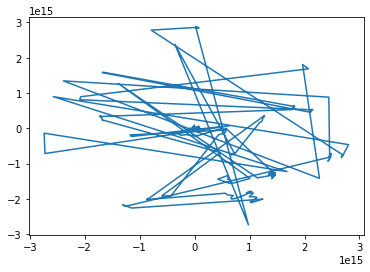

In [13]:
x = []
y = []
z = []

for p in position_2:
    x.append(p[0])
    y.append(p[1])
    z.append(p[2])
    
plt.plot(x[:], y[:], '-')
plt.show()